<a href="https://colab.research.google.com/github/dallinmoore/avalanche-forecasting/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Avalanche Danger

Project by Dallin Moore

---
## Details
Class: DATA 5610 - Deep Learning

Assignment: Final Project

Prof.: Dr. Sharad Jones

## Imports and Constants

In [1]:
import pandas as pd
import numpy as np

import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import date
from pathlib import Path
from typing import Dict, List

from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


# CONSTANTS
BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"


## Fetch SNOTEL Station Data

In [ ]:
def fetch_snotel_metadata():
    metadata_url = BASE_URL + "stations"
    params = {
        "stationTriplets": "*:UT:SNTL",
        "returnForecastPointMetadata": "false",
        "returnReservoirMetadata": "false",
        "returnStationElements": "false",
        "activeOnly": "true",
        "durations": "HOURLY",
    }
    response = requests.get(metadata_url, params=params, timeout=30)
    if response.ok:
        return response.json()
    print("Request failed with status code:", response.status_code)
    return []

keys = [
    "stationId",
    "stateCode",
    "networkCode",
    "name",
    "countyName",
    "elevation",
    "latitude",
    "longitude",
    "beginDate"
]

data = fetch_snotel_metadata()
snotel_df = pd.DataFrame([{key: station.get(key, "") for key in keys} for station in data])
snotel_df.head()

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate
0,907,UT,SNTL,Agua Canyon,Kane,8890.0,37.52217,-112.27118,1994-10-01 00:00
1,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00
2,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00
3,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00


### Categorize Stations by Region

In [ ]:
region_boundaries = {
    "Logan": [[41.2, -111.9], [42.0, -111.9], [42.0, -111.1], [41.2, -111.1]],
    "Ogden": [[40.8, -112.0], [41.2, -112.0], [41.2, -111.1], [40.8, -111.1]],
    "Salt Lake": [[40.4, -112.0], [40.8, -112.0], [40.8, -111.1], [40.4, -111.1]],
    "Uintas": [[40.3, -111.1], [41.0, -111.1], [41.0, -109.4], [40.3, -109.4]],
    "Provo": [[39.8, -112.0], [40.4, -112.0], [40.4, -111.1], [39.8, -111.1]],
    "Skyline": [[38.9, -111.8], [39.8, -111.8], [39.8, -111.1], [38.9, -111.1]],
    "Moab": [[38.0, -109.8], [39.0, -109.8], [39.0, -108.9], [38.0, -108.9]],
    "Abajos": [[37.5, -109.9], [37.9, -109.9], [37.9, -109.1], [37.5, -109.1]],
    "Southwest": [[37.0, -114.0], [38.5, -114.0], [38.5, -112.5], [37.0, -112.5]],
}

SNOTEL stations that are not in the boundaries, but are within 0.3 degrees (roughly 20 miles) are grouped into that region. So some stations are used by multiple regions and some are not included.

In [ ]:
region_shapes = {r: Polygon(c) for r, c in region_boundaries.items()}
_poly_list = list(region_shapes.values())
_region_tree = STRtree(_poly_list)

# Two parallel maps so we handle both pygeos‑style (int indices) *and* Shapely 2.x (clone geoms)
_poly_idx_to_region = {idx: region for idx, region in enumerate(region_shapes)}
_poly_wkb_to_region = {poly.wkb: region for region, poly in region_shapes.items()}

def determine_region(lat, lon, min_distance_threshold=0.1):
    """Return **all** regions whose polygon either contains the point or lies
    within *min_distance_threshold* degrees of it.

    Uses a buffered point when querying the STRtree, so regions whose bounding
    box is within the threshold are considered even if the point itself is
    just outside the box.  Works with both Shapely‑2 (geometries returned) and
    older PyGEOS/Shapely‑1 (integer indices returned).
    """
    pt   = Point(lat, lon)               # (lat, lon) order preserved
    buf  = pt.buffer(min_distance_threshold)  # degrees

    regions = []
    for item in _region_tree.query(buf):  # buffered query widens candidate set
        # Shapely‑1 / PyGEOS ⇒ index; Shapely‑2 ⇒ geometry clone
        if isinstance(item, (int, np.integer)):
            poly   = _poly_list[item]
            region = _poly_idx_to_region[item]
        else:
            poly   = item
            region = _poly_wkb_to_region[poly.wkb]

        if poly.contains(pt) or poly.exterior.distance(pt) <= min_distance_threshold:
            regions.append(region)

    return regions


def map_stations_to_regions(df):
    region_stations = {r: [] for r in region_boundaries}
    for _, row in df.iterrows():
        regs = determine_region(row["latitude"], row["longitude"])
        if not regs:
            continue
        st = {
            "stationId": row["stationId"],
            "name": row["name"],
            "elevation": row["elevation"],
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "beginDate": row["beginDate"],
        }
        for r in regs:
            region_stations[r].append(st)

    print("SNOTEL Stations mapped to regions:")
    for region, stations in region_stations.items():
        print(f"{region}: {len(stations)} stations")

    return region_stations

region_stations = map_stations_to_regions(snotel_df)

region_stations['Logan'][:5]

SNOTEL Stations mapped to regions:
Logan: 17 stations
Ogden: 13 stations
Salt Lake: 19 stations
Uintas: 29 stations
Provo: 11 stations
Skyline: 18 stations
Moab: 3 stations
Abajos: 3 stations
Southwest: 15 stations


[{'stationId': '332',
  'name': 'Ben Lomond Peak',
  'elevation': 7700.0,
  'latitude': 41.37603,
  'longitude': -111.94405,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '333',
  'name': 'Ben Lomond Trail',
  'elevation': 5980.0,
  'latitude': 41.38291,
  'longitude': -111.92103,
  'beginDate': '1980-06-03 00:00'},
 {'stationId': '374',
  'name': 'Bug Lake',
  'elevation': 7980.0,
  'latitude': 41.68541,
  'longitude': -111.41987,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '455',
  'name': 'Dry Bread Pond',
  'elevation': 8290.0,
  'latitude': 41.41289,
  'longitude': -111.5377,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '1114',
  'name': 'Garden City Summit',
  'elevation': 7680.0,
  'latitude': 41.9215,
  'longitude': -111.4693,
  'beginDate': '2009-10-01 00:00'}]

### Visualize the Stations/Regions

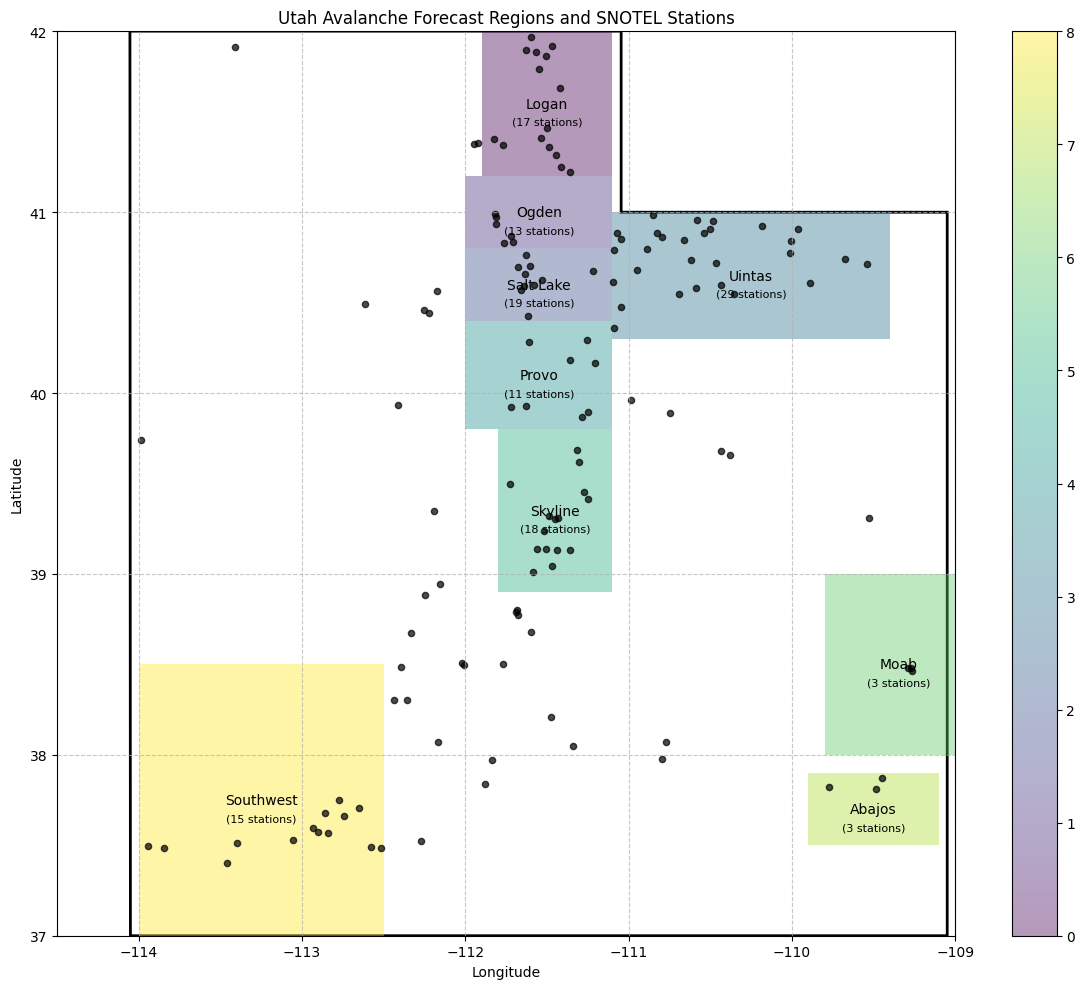

In [ ]:
def visualize_regions(snotel_df, region_stations, region_boundaries):
    colors = list(mcolors.TABLEAU_COLORS)

    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    utah_boundary = [
        [42.001, -114.053],
        [42.001, -111.046],
        [41.000, -111.046],
        [41.000, -109.050],
        [37.000, -109.050],
        [37.000, -114.050],
        [42.001, -114.053],
    ]

    utah_coords = np.array(utah_boundary)[:, [1, 0]]
    utah_polygon = MplPolygon(utah_coords, closed=True, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(utah_polygon)

    patches, region_centroids = [], {}
    for coords in region_boundaries.values():
        patches.append(MplPolygon(np.array(coords)[:, [1, 0]], closed=True, fill=True))

    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.arange(len(patches)))
    ax.add_collection(p)
    plt.colorbar(p)

    for region_name, coords in region_boundaries.items():
        centroid_x = np.mean([p[1] for p in coords])
        centroid_y = np.mean([p[0] for p in coords])
        region_centroids[region_name] = (centroid_x, centroid_y)
        ax.text(centroid_x, centroid_y, region_name, fontsize=10, ha="center", va="center")

    ax.scatter(snotel_df["longitude"], snotel_df["latitude"], c="black", s=20, alpha=0.7, label="SNOTEL Stations")

    for region_name, (x, y) in region_centroids.items():
        ax.text(x, y - 0.1, f"({len(region_stations[region_name])} stations)", fontsize=8, ha="center", va="center")

    ax.set_xlim(-114.5, -109.0)
    ax.set_ylim(37.0, 42.0)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Utah Avalanche Forecast Regions and SNOTEL Stations")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


visualize_regions(snotel_df, region_stations, region_boundaries)

The boundaries are meant to closely match the map used by the [Utah Avalanche Center](https://utahavalanchecenter.org/). Because there are so few stations in the Abajos and Moab region, and their weather patterns differ significantly from the northern 6 regions, they will be ommited. The Southwest region is being ommited as there are no longer avalanche predictions for it.

In [ ]:
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [ ]:
def get_unique_station_ids(region_stations, regions):
    return list({st["stationId"] for reg in regions for st in region_stations[reg]})

unique_ids = get_unique_station_ids(region_stations, regions)
len(unique_ids)

86

### Explode Dataset to Cover Every Station in Every Region

In [ ]:
# Compute a list of regions for each station
snotel_df["regions"] = snotel_df.apply(
    lambda row: determine_region(row["latitude"], row["longitude"]),
    axis=1
)

# drop any stations that don’t fall in _any_ region:
snotel_df = snotel_df[snotel_df["regions"].map(len) > 0]

# Explode the list of regions into one row per (station, region) pair
snotel_df = (
    snotel_df
    .explode("regions")
    .rename(columns={"regions": "Region"})
    .reset_index(drop=True)
)

snotel_df

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region
0,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00,Salt Lake
1,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00,Uintas
2,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00,Skyline
3,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00,Salt Lake
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00,Uintas
...,...,...,...,...,...,...,...,...,...,...
123,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Provo
124,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Salt Lake
125,1164,UT,SNTL,Wolf Creek Peak,Wasatch,9770.0,40.47733,-111.04469,2020-08-26 00:00,Uintas
126,1228,UT,SNTL,Wrigley Creek,Sanpete,9330.0,39.13233,-111.35685,2012-10-01 00:00,Skyline


### Map Each Station to an Elevation Band

Elevation bands are from [Utah Avalanche Center](https://utahavalanchecenter.org/) that are used for their forecasts.

In [ ]:
region_elevations = [
  {
    "region": "Logan",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Ogden",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Uintas",
    "elevation_levels": {
      "level_1": {"max": 9500, "min": 0},
      "level_2": {"max": 10000, "min": 9501},
      "level_3": {"max": 20000, "min": 10001}
    }
  },
  {
    "region": "Salt Lake",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Provo",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Skyline",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501
      }
    }
  }
]

In [ ]:
elevation_lookup = {item["region"]: item["elevation_levels"] for item in region_elevations}

def get_elevation_level(elevation, region):
    levels = elevation_lookup.get(region)
    if not levels:
        return 0

    if elevation <= levels["level_1"]["max"]:
        return 1
    if elevation <= levels["level_2"]["max"]:
        return 2
    return 3

# compute elevation_level for each row
snotel_df["elevation_level"] = snotel_df.apply(
    lambda row: get_elevation_level(row["elevation"], row["Region"]),
    axis=1
)

counts = (
    snotel_df
    .groupby(["Region", "elevation_level"])
    .stationId
    .nunique()             # or .size() if you’re OK with counting duplicates
    .reset_index(name="count")
)

# print it as a table
print("Stations per region by elevation level:")
for region in counts["Region"].unique():
    sub = counts[counts["Region"] == region]
    print(f"\n{region}:")
    for _, row in sub.sort_values("elevation_level").iterrows():
        lvl = row["elevation_level"]
        cnt = row["count"]
        print(f"  Level {lvl}: {cnt} stations")


Stations per region by elevation level:

Abajos:
  Level 0: 3 stations

Logan:
  Level 1: 4 stations
  Level 2: 11 stations
  Level 3: 2 stations

Moab:
  Level 0: 3 stations

Ogden:
  Level 1: 3 stations
  Level 2: 9 stations
  Level 3: 1 stations

Provo:
  Level 1: 5 stations
  Level 2: 5 stations
  Level 3: 1 stations

Salt Lake:
  Level 1: 6 stations
  Level 2: 12 stations
  Level 3: 1 stations

Skyline:
  Level 1: 4 stations
  Level 2: 10 stations
  Level 3: 4 stations

Southwest:
  Level 0: 15 stations

Uintas:
  Level 1: 17 stations
  Level 2: 5 stations
  Level 3: 7 stations


In [ ]:
snotel_df.sort_values(['Region', 'elevation_level'])

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
13,1153,UT,SNTL,Buckboard Flat,San Juan,8920.0,37.86943,-109.44717,2012-10-01 00:00,Abajos,0
16,383,UT,SNTL,Camp Jackson,San Juan,8840.0,37.81333,-109.48723,1985-10-01 00:00,Abajos,0
37,1323,UT,SNTL,Elk Ridge,San Juan,8540.0,37.82308,-109.77156,2024-10-01 00:00,Abajos,0
6,333,UT,SNTL,Ben Lomond Trail,Weber,5980.0,41.38291,-111.92103,1980-06-03 00:00,Logan,1
70,582,UT,SNTL,Little Bear,Cache,6540.0,41.40562,-111.82607,1978-10-01 00:00,Logan,1
...,...,...,...,...,...,...,...,...,...,...,...
40,481,UT,SNTL,Five Points Lake,Duchesne,10920.0,40.71785,-110.46721,1980-08-14 00:00,Uintas,3
63,566,UT,SNTL,Lakefork #1,Duchesne,10120.0,40.59709,-110.43316,1978-10-01 00:00,Uintas,3
65,513,UT,SNTL,Lakefork Basin,Duchesne,10890.0,40.73785,-110.62121,1982-10-01 00:00,Uintas,3
107,1117,UT,SNTL,Spirit Lk,Daggett,10240.0,40.83868,-110.00527,2009-10-01 00:00,Uintas,3


## Fetch the Timeseries SNOTEL Data

In [ ]:
snotel_elements = {
    "Snow_Depth": "SNWD",
    "SWE": "WTEQ",
    "Precipitation_Increment": "PRCP",
    "Snow_Density": "SNDN",
    "Avg_Temp": "TAVG",
    "Max_Temp": "TMAX",
    "Min_Temp": "TMIN",
    "Avg_Wind_Speed": "WSPDV",
    "Max_Wind_Speed": "WSPDX",
    "Avg_Wind_Direction": "WDIRV",
    "Max_Wind_Direction": "WDIRX",
    "Avg_Snow_Temperature": "SNTP",
    "Max_Snow_Temperature": "SNTX",
    "Min_Snow_Temperature": "SNTN",
    "Solar_Radiation": "SRADV",
    "Solar_Radiation_Max": "SRADX",
    "Relative_Humidity": "RHUMV",
    "Max_Relative_Humidity": "RHUMX",
    "Min_Relative_Humidity": "RHUMN",
}

In [ ]:
def fetch_snotel_data(triplet, begin_date, end_date, elements):
    data_url = BASE_URL + "data"
    params = {
        "stationTriplets": triplet,
        "beginDate": begin_date,
        "endDate": end_date,
        "elements": ",".join(elements.values()),
        "duration": "DAILY",
    }
    for _ in range(2):
        try:
            resp = requests.get(data_url, params=params, timeout=60)
            if resp.ok:
                return resp.json()
        except Exception as e:
            print(f"Retrying {triplet} after error: {e}")
    print("Failed:", triplet)
    return []


def process_station_data(station_id, start_date, end_date, elements):
    triplet = f"{station_id}:UT:SNTL"
    series = []
    for site in fetch_snotel_data(triplet, start_date, end_date, elements):
        for element in site.get("data", []):
            code = element["stationElement"]["elementCode"]
            col = next(k for k, v in elements.items() if v == code)
            for val in element.get("values", []):
                rec = next((r for r in series if r["Date"] == val["date"]), None)
                if rec is None:
                    rec = {"Date": val["date"], "stationId": station_id}
                    series.append(rec)
                rec[col] = val.get("value")
    return series


def fetch_all_snotel_data( ids, elements, start_date, end_date=date.today().strftime("%Y-%m-%d"), max_workers=15,):
    total = len(ids)
    print(f"Fetching daily SNOTEL data for {total} stations…")

    all_rows = []
    done = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {
            ex.submit(process_station_data, sid, start_date, end_date, elements): sid
            for sid in ids
        }

        for fut in as_completed(futures):
            sid = futures[fut]
            try:
                all_rows.extend(fut.result())
            except Exception as e:
                # keep going, but show which station failed
                print(f"  ✖ {sid} → {e}")
            done += 1

            # Print progress every 10 stations or on the last one
            if done % 10 == 0 or done == total:
                print(f"  {done}/{total} stations complete ({done / total:.0%})")

    return pd.DataFrame(all_rows)



snotel_df_ts_raw = fetch_all_snotel_data(unique_ids, snotel_elements, "2013-12-13")
snotel_df_ts = snotel_df_ts_raw.copy()
snotel_df_ts.head()

Fetching daily SNOTEL data for 86 stations…
  10/86 stations complete (12%)
  20/86 stations complete (23%)
  30/86 stations complete (35%)
  40/86 stations complete (47%)
  50/86 stations complete (58%)
  60/86 stations complete (70%)
  70/86 stations complete (81%)
  80/86 stations complete (93%)
  86/86 stations complete (100%)


,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,2020-10-01,1164,0.0,0.0,50.4,65.7,36.3,0.0,NaN,NaN,NaN,NaN
1,2020-10-02,1164,0.0,0.0,48.0,61.9,39.9,0.0,NaN,NaN,NaN,NaN
2,2020-10-03,1164,0.0,0.0,49.5,63.3,37.4,0.0,NaN,NaN,NaN,NaN
3,2020-10-04,1164,0.0,0.0,49.6,62.2,39.4,0.0,NaN,NaN,NaN,NaN
4,2020-10-05,1164,0.0,0.0,48.2,64.2,36.3,0.0,NaN,NaN,NaN,NaN


### Look For Anomolies in the Data

In [ ]:
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,345571.000000,345649.000000,344205.000000,344225.000000,344139.000000,345664.000000,171396.000000,12912.000000,12908.000000,12908.000000
mean,0.085828,17.155293,39.139022,50.859907,28.563042,5.309089,29.484341,218.942844,4.981817,17.047420
std,0.214978,23.024673,16.301142,17.679461,15.830568,8.132506,9.063322,283.786806,3.839697,7.217179
min,0.000000,0.000000,-147.800000,-147.800000,-147.800000,0.000000,6.200000,-100.000000,-99.900000,-99.900000
25%,0.000000,0.000000,26.600000,36.900000,17.400000,0.000000,22.900000,141.000000,2.600000,12.100000
50%,0.000000,4.000000,37.900000,49.500000,28.800000,0.800000,27.900000,242.000000,3.400000,15.600000
75%,0.100000,30.000000,53.100000,66.000000,40.800000,8.400000,35.300000,284.000000,6.100000,20.900000
max,5.700000,229.000000,83.700000,132.100000,83.700000,82.800000,65.000000,18922.000000,26.100000,56.800000


Investigate the anomilies.

In [ ]:
snotel_df_ts[snotel_df_ts["Avg_Wind_Speed"] <= -99]

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
299301,2024-12-04,828,0.0,20.0,NaN,NaN,NaN,4.4,22.0,-100.0,-99.9,-99.9


In [ ]:
snotel_df_ts[snotel_df_ts["Max_Temp"] <= -140]

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
69244,2025-04-16,1300,0.0,54.0,-147.8,-147.8,-147.8,23.6,43.7,NaN,NaN,NaN


In [ ]:
snotel_df_ts[snotel_df_ts["Avg_Wind_Direction"] >= 18000]

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
192095,2022-07-09,742,0.0,0.0,60.6,71.4,49.3,0.0,NaN,18626.0,NaN,NaN
192096,2022-07-10,742,0.0,0.0,63.3,72.7,52.5,0.0,NaN,18922.0,NaN,NaN


Now remove the anomolies. In production this could be done using anomoly detection: if there is a reading that is too many standard deviations away from the mean, the data is removed.

In [ ]:
# Identify the rows you want to modify
mask = (snotel_df_ts["Avg_Wind_Speed"] <= -99)
snotel_df_ts.loc[mask, ["Avg_Wind_Speed", "Max_Wind_Speed"]] = np.nan

mask = (snotel_df_ts["Max_Temp"] <= -140)
snotel_df_ts.loc[mask, ["Avg_Temp", "Max_Temp", "Min_Temp"]] = np.nan

mask = ((snotel_df_ts["Avg_Wind_Direction"] > 360) | (snotel_df_ts["Avg_Wind_Direction"] < 0))
snotel_df_ts.loc[mask, ["Avg_Wind_Direction"]] = np.nan

snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,345571.000000,345649.000000,344204.000000,344224.000000,344138.000000,345664.000000,171396.000000,12905.000000,12907.000000,12907.000000
mean,0.085828,17.155293,39.139565,50.860484,28.563554,5.309089,29.484341,214.315924,4.989943,17.056481
std,0.214978,23.024673,16.298052,17.676244,15.827736,8.132506,9.063322,86.027084,3.727200,7.143663
min,0.000000,0.000000,-147.800000,-6.900000,-36.000000,0.000000,6.200000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.600000,36.900000,17.400000,0.000000,22.900000,141.000000,2.600000,12.100000
50%,0.000000,4.000000,37.900000,49.500000,28.800000,0.800000,27.900000,242.000000,3.400000,15.600000
75%,0.100000,30.000000,53.100000,66.000000,40.800000,8.400000,35.300000,284.000000,6.100000,20.900000
max,5.700000,229.000000,83.700000,132.100000,83.700000,82.800000,65.000000,360.000000,26.100000,56.800000


In [ ]:
len(snotel_df_ts)

345668

### Convert Wind Direction to Cyclical Pair

In [ ]:
snotel_df_ts["Avg_Wind_Direction_sin"] = np.sin(np.deg2rad(snotel_df_ts["Avg_Wind_Direction"]))
snotel_df_ts["Avg_Wind_Direction_cos"] = np.cos(np.deg2rad(snotel_df_ts["Avg_Wind_Direction"]))

snotel_df_ts = snotel_df_ts.drop(columns=["Avg_Wind_Direction"])        # keep only sin / cos
snotel_df_ts.sort_values("Avg_Wind_Direction_sin").head()

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Speed,Max_Wind_Speed,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos
192930,2024-10-21,742,0.0,0.0,39.0,46.0,32.2,0.0,NaN,4.4,11.4,-1.0,-1.836970e-16
189703,2015-12-21,742,0.6,19.0,22.8,26.1,17.6,4.0,21.1,17.9,37.9,-1.0,-1.836970e-16
191399,2020-08-12,742,0.0,0.0,59.5,66.7,53.4,0.0,NaN,10.9,29.5,-1.0,-1.836970e-16
196114,2022-01-11,435,0.0,38.0,22.5,39.6,11.1,8.5,22.4,2.7,12.8,-1.0,-1.836970e-16
195564,2020-07-10,435,0.0,0.0,64.0,78.8,47.1,0.0,NaN,2.8,13.0,-1.0,-1.836970e-16


## Combine the Metadata with Time-series Data

In [ ]:
snotel_df["stationId"] = snotel_df["stationId"].astype(int)
snotel_df_ts["stationId"] = snotel_df_ts["stationId"].astype(int)
snotel_df["stationId"].head()

,stationId
0,1308
1,992
2,329
3,330
4,330


In [ ]:
snotel_dataset = (
    snotel_df_ts
    .merge(
        snotel_df,
        on=["stationId"],
        how="left",
    )
).sort_values(['Region', 'Date', 'elevation_level']).reset_index(drop=True)
snotel_dataset.head()

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Speed,...,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
0,2013-12-13,1118,0.0,4.0,12.2,27.0,4.1,1.1,27.5,NaN,...,UT,SNTL,Lost Creek Resv,Morgan,6070.0,41.22155,-111.35947,2010-10-01 00:00,Logan,1
1,2013-12-13,1113,0.0,6.0,17.8,32.4,8.8,1.3,21.7,NaN,...,UT,SNTL,Tony Grove RS,Cache,6320.0,41.88573,-111.56918,2009-10-01 00:00,Logan,1
2,2013-12-13,333,0.2,18.0,21.2,30.4,13.1,2.6,14.4,NaN,...,UT,SNTL,Ben Lomond Trail,Weber,5980.0,41.38291,-111.92103,1980-06-03 00:00,Logan,1
3,2013-12-13,582,0.3,11.0,21.6,29.8,17.1,2.9,26.4,NaN,...,UT,SNTL,Little Bear,Cache,6540.0,41.40562,-111.82607,1978-10-01 00:00,Logan,1
4,2013-12-13,1013,0.0,15.0,19.2,24.4,13.8,3.4,22.7,NaN,...,UT,SNTL,Temple Fork,Cache,7420.0,41.79300,-111.54605,2001-11-05 00:00,Logan,2


In [ ]:
len(snotel_dataset)

426849

### Which Regions have wind data?

In [ ]:
snotel_dataset[snotel_dataset["Avg_Wind_Speed"] >= 0]["Region"].value_counts()

,count
Region,
Ogden,4492
Provo,4175
Skyline,4052
Salt Lake,2733
Uintas,188


In the SNOTEL dataset, there are only a few stations that provide wind data, but given that this is data is free and easily accessible, I will not supplement with data from other sources (I have considered and ruled out collecting data from sources like NOAA, MesoNet, ERA5).

Due to the limited data in the Uintas Region, and no data in the Logan Region I will ommit these two regions for the rest of my analysis.

In [ ]:
regions = ["Ogden", "Salt Lake", "Provo", "Skyline"]

In [ ]:
snotel_dataset = snotel_dataset[snotel_dataset['Region'].isin(regions)].sort_values(['Region', 'Date', 'elevation_level']).reset_index(drop=True)
snotel_dataset["Region"].value_counts()

,count
Region,
Skyline,75563
Salt Lake,68216
Ogden,52497
Provo,42680


In [ ]:
len(snotel_dataset)

238956

### Aggregate the Data For Each Region, Elevation Level, and Day

In [ ]:
# Ensure Date is a datetime and sort
snotel_dataset.loc[:, 'Date'] = pd.to_datetime(snotel_dataset['Date'])
snotel_dataset.head()

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,Avg_Wind_Speed,...,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate,Region,elevation_level
0,2013-12-13 00:00:00,1118,0.0,4.0,12.2,27.0,4.1,1.1,27.5,NaN,...,UT,SNTL,Lost Creek Resv,Morgan,6070.0,41.22155,-111.35947,2010-10-01 00:00,Ogden,1
1,2013-12-13 00:00:00,972,0.0,16.0,16.3,26.4,9.9,4.0,25.0,2.3,...,UT,SNTL,Louis Meadow,Salt Lake,6750.0,40.83033,-111.76457,1999-10-01 00:00,Ogden,1
2,2013-12-13 00:00:00,1054,0.0,19.0,15.6,28.0,8.8,4.4,23.2,NaN,...,UT,SNTL,Farmington Lower,Davis,6850.0,40.99200,-111.81702,2003-11-20 00:00,Ogden,1
3,2013-12-13 00:00:00,896,0.0,18.0,23.4,32.5,15.3,4.0,22.2,NaN,...,UT,SNTL,Hardscrabble,Morgan,7270.0,40.86833,-111.71865,1993-10-01 00:00,Ogden,2
4,2013-12-13 00:00:00,596,0.0,26.0,20.7,28.8,11.8,5.6,21.5,NaN,...,UT,SNTL,Lookout Peak,Salt Lake,8150.0,40.83731,-111.70965,1988-06-23 00:00,Ogden,2


In [ ]:
# Custom aggregation functions for cyclical variables
def circular_mean_sin(series):
    """Calculate circular mean for sin component"""
    angles = np.arctan2(series, snotel_dataset['Avg_Wind_Direction_cos'].loc[series.index])
    return np.sin(np.mean(angles))

def circular_mean_cos(series):
    """Calculate circular mean for cos component"""
    angles = np.arctan2(snotel_dataset['Avg_Wind_Direction_sin'].loc[series.index], series)
    return np.cos(np.mean(angles))

# Define which columns to aggregate and how
agg_map = {
    'Precipitation_Increment': 'max',
    'Snow_Depth':              'max',
    'SWE':                     'max',
    'Avg_Temp':                'mean',
    'Max_Temp':                'max',
    'Min_Temp':                'min',
    'Snow_Density':            'mean',
    'Avg_Wind_Direction_sin':  circular_mean_sin,
    'Avg_Wind_Direction_cos':  circular_mean_cos,
    'Avg_Wind_Speed':          'mean',
    'Max_Wind_Speed':          'max'
}

# Perform the aggregation
snotel_dataset_agg = (
    snotel_dataset
    .groupby(['Region', 'Date', 'elevation_level'], as_index=False)
    .agg(agg_map)
    .sort_values(['Region', 'Date', 'elevation_level'])
)

snotel_dataset_agg.sort_values(['Region', 'Date', 'elevation_level']).head()

,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed
0,Ogden,2013-12-13,1,0.0,19.0,4.4,14.700000,28.0,4.1,25.233333,0.987688,0.156434,2.3,9.3
1,Ogden,2013-12-13,2,0.2,31.0,6.2,21.937500,32.5,8.4,20.387500,NaN,NaN,NaN,NaN
2,Ogden,2013-12-13,3,0.0,28.0,6.7,19.600000,25.7,11.5,23.900000,NaN,NaN,NaN,NaN
3,Ogden,2013-12-14,1,0.0,18.0,4.4,18.133333,28.4,3.9,26.200000,0.882948,0.469472,2.0,7.8
4,Ogden,2013-12-14,2,0.0,30.0,6.2,20.250000,30.0,8.1,21.087500,NaN,NaN,NaN,NaN


In [ ]:
len(snotel_dataset_agg)

45476

### Add a Row for Every Region, Date, and Elevation Level

In [ ]:
def ensure_complete_forecast_grid(df, regions, dates, elev_levels):
    """
    Ensure the DataFrame has the same number of rows for every region by creating
    a complete grid of Region, Date, and elevation_level combinations.
    Missing danger rating values are filled with zeros.

    Parameters:
    df (pd.DataFrame): DataFrame with columns Date, Region, elevation_level, Link, and danger ratings
    regions (list): List of all region names
    dates (list or pd.DatetimeIndex): List of all dates
    elev_levels (list): List of elevation levels (e.g., [1, 2, 3])

    Returns:
    pd.DataFrame: DataFrame with complete grid and filled values
    """
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Create full MultiIndex
    full_index = pd.MultiIndex.from_product(
        [regions, dates, elev_levels],
        names=['Region', 'Date', 'elevation_level']
    )

    # Reindex the DataFrame
    complete_df = (
        df.set_index(['Region', 'Date', 'elevation_level'])
        .reindex(full_index)
        .reset_index()
    )

    # Identify danger rating columns (all except Date, Region, elevation_level, Link)
    metadata_cols = ['Date', 'Region', 'elevation_level', 'Link']
    danger_cols = [col for col in df.columns if col not in metadata_cols]

    # Fill missing danger ratings with 0
    for col in danger_cols:
        complete_df[col] = complete_df[col].fillna(0)

    # Ensure correct data types
    complete_df['Date'] = pd.to_datetime(complete_df['Date'])
    complete_df['Region'] = complete_df['Region'].astype(str)
    complete_df['elevation_level'] = complete_df['elevation_level'].astype(int)

    # Link remains NaN for new records
    return complete_df


# Define regions, dates, and elevation levels
regions = snotel_dataset_agg['Region'].unique()
dates = pd.date_range(
    start=snotel_dataset_agg['Date'].min(),
    end=snotel_dataset_agg['Date'].max(),
    freq='D'
)
elev_levels = [1, 2, 3]

# Apply the function
snotel_dataset_agg = ensure_complete_forecast_grid(snotel_dataset_agg, regions, dates, elev_levels)

snotel_dataset_agg["Region"].value_counts()

,count
Region,
Ogden,12594
Provo,12594
Salt Lake,12594
Skyline,12594


In [ ]:
len(snotel_dataset_agg)

50376

### Fill NaN Values

In [ ]:
def fill_missing_by_elevation_vectorized(df: pd.DataFrame, data_cols: list) -> pd.DataFrame:
    """
    Vectorized fill of NaNs within each (Region, Date) across elevation_level 1,2,3:
      1. Pivot to wide form with elevation_level as columns.
      2. For each data column:
         - Compute mean of levels 1 & 3 (skipna=True) to derive level 2 where missing.
         - Fill level 2 with that mean.
         - Propagate level 2 values to levels 1 & 3 where they are NaN.
      3. Stack back to long form.
    All assignments use .loc or direct column assignment to avoid chained-assignment.
    """
    idx = ['Region', 'Date']
    # pivot to wide: MultiIndex columns (data_col, elevation_level)
    df_wide = df.pivot(index=idx, columns='elevation_level', values=data_cols)

    for col in data_cols:
        # pull the three series
        s1 = df_wide[(col, 1)]
        s2 = df_wide[(col, 2)]
        s3 = df_wide[(col, 3)]

        # compute mean of level 1 & 3 where at least one is present
        mean13 = pd.concat([s1, s3], axis=1).mean(axis=1)

        # Fill s2 where it's NaN
        filled_s2 = s2.fillna(mean13)

        # Assign back in one shot
        df_wide.loc[:, (col, 2)] = filled_s2

        # Propagate to 1 & 3 in one shot
        df_wide.loc[:, (col, 1)] = s1.fillna(filled_s2)
        df_wide.loc[:, (col, 3)] = s3.fillna(filled_s2)

    # Stack elevation_level back into a column
    df_filled = (
        df_wide
        .stack(level='elevation_level')  # now columns are data_cols again
        .reset_index()
    )

    return df_filled


weather_cols = [
    'Precipitation_Increment', 'Snow_Depth', 'SWE', 'Snow_Density',
    'Avg_Temp', 'Max_Temp', 'Min_Temp',
    'Avg_Wind_Direction_sin', 'Avg_Wind_Direction_cos', 'Avg_Wind_Speed', 'Max_Wind_Speed'
]

# Apply to your aggregated DataFrame:
snotel_dataset_agg_full = fill_missing_by_elevation_vectorized(
    snotel_dataset_agg,
    weather_cols
)

snotel_dataset_agg_full.sort_values(['Region', 'Date', 'elevation_level']).head()


<ipython-input-52-1663813163>:38: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level='elevation_level')  # now columns are data_cols again


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Snow_Density,Avg_Temp,Max_Temp,Min_Temp,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed
0,Ogden,2013-12-13,1,0.0,19.0,4.4,25.233333,14.700000,28.0,4.1,0.987688,0.156434,2.3,9.3
1,Ogden,2013-12-13,2,0.2,31.0,6.2,20.387500,21.937500,32.5,8.4,0.000000,0.000000,0.0,0.0
2,Ogden,2013-12-13,3,0.0,28.0,6.7,23.900000,19.600000,25.7,11.5,0.000000,0.000000,0.0,0.0
3,Ogden,2013-12-14,1,0.0,18.0,4.4,26.200000,18.133333,28.4,3.9,0.882948,0.469472,2.0,7.8
4,Ogden,2013-12-14,2,0.0,30.0,6.2,21.087500,20.250000,30.0,8.1,0.000000,0.000000,0.0,0.0


If there are any NaN values  in the `Snow_Density` column, they will need to be manually computed where they are missing using `Snow_Depth` and `SWE` (snow water equivilent).

In [ ]:
mask_missing = snotel_dataset_agg_full['Snow_Density'].isna()

# of those rows where either SWE or Snow_Depth is zero, density = 0
mask_zero = mask_missing & (
    (snotel_dataset_agg_full['SWE'] == 0) |
    (snotel_dataset_agg_full['Snow_Depth'] == 0)
)
snotel_dataset_agg_full.loc[mask_zero, 'Snow_Density'] = 0

# of the remaining missing rows where both SWE and depth are non-zero, compute ratio
mask_compute = mask_missing & (
    snotel_dataset_agg_full['SWE'].notna() &
    snotel_dataset_agg_full['Snow_Depth'].notna() &
    (snotel_dataset_agg_full['Snow_Depth'] != 0) &
    (snotel_dataset_agg_full['SWE'] != 0)
)
snotel_dataset_agg_full.loc[mask_compute, 'Snow_Density'] = (
    snotel_dataset_agg_full.loc[mask_compute, 'SWE']
    / snotel_dataset_agg_full.loc[mask_compute, 'Snow_Depth']
)

new_fill_mask = mask_zero | mask_compute
snotel_dataset_agg_full.loc[new_fill_mask].head()


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Snow_Density,Avg_Temp,Max_Temp,Min_Temp,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed


Any remaining NaN values in avererage temperature will be filled using max/min temperature.

In [ ]:
mask_avg_fill = (
    snotel_dataset_agg_full['Avg_Temp'].isna() &
    snotel_dataset_agg_full['Max_Temp'].notna() &
    snotel_dataset_agg_full['Min_Temp'].notna()
)

snotel_dataset_agg_full.loc[mask_avg_fill, 'Avg_Temp'] = (
    snotel_dataset_agg_full.loc[mask_avg_fill, 'Max_Temp'] +
    snotel_dataset_agg_full.loc[mask_avg_fill, 'Min_Temp']
) / 2

snotel_dataset_agg_full.loc[mask_avg_fill].head()


,Region,Date,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Snow_Density,Avg_Temp,Max_Temp,Min_Temp,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed


The remaining NaN values will be forward filled.

In [ ]:
# sort the data
snotel_dataset_agg_full.sort_values(
    ['Region', 'elevation_level', 'Date'],
    inplace=True
)

# forward‐fill within each Region / elevation_level group
snotel_dataset_agg_full = (
    snotel_dataset_agg_full
    .groupby(['Region', 'elevation_level'], group_keys=False)
    .apply(lambda grp: grp.ffill())
    .reset_index(drop=True)
)

# 3) Quick check for any remaining NaNs
snotel_dataset_agg_full.isna().any()

<ipython-input-55-458848558>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.ffill())


,0
Region,False
Date,False
elevation_level,False
Precipitation_Increment,False
Snow_Depth,False
SWE,False
Snow_Density,False
Avg_Temp,False
Max_Temp,False
Min_Temp,False


## Read Avalanch Forecast Dataset

In [ ]:
avy_forecast_df = pd.read_csv("avalanche-forecast-rose.csv")
avy_forecast_df.head()

,Date Issued,Forecast Area,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3/7/2024,Moab,https://utahavalanchecenter.org/forecast/moab/...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0


In [ ]:
avy_forecast_df = avy_forecast_df.rename(columns={"Forecast Area": "Region", "Date Issued": "Date"})
avy_forecast_df.head()

,Date,Region,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3/7/2024,Moab,https://utahavalanchecenter.org/forecast/moab/...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0


In [ ]:
# Drop unused regions
avy_forecast_df = avy_forecast_df[avy_forecast_df["Region"].isin(regions)]
set(avy_forecast_df['Region'])

{'Ogden', 'Provo', 'Salt Lake', 'Skyline'}

In [ ]:
avy_forecast_df.loc[:, "Date"] = pd.to_datetime(avy_forecast_df["Date"])


In [ ]:
avy_forecast_df.shape

(6918, 27)

### Remove Duplicate Forecasts

Some forecasts have multiple links that translate to rows that are identical or nearly identical.

In [ ]:
# Check for duplicates on ['Date', 'elevation_level', 'Region']
duplicates = avy_forecast_df[
    avy_forecast_df.duplicated(
        subset=['Date', 'Region'], keep=False
    )
]

len(duplicates)


34

In [ ]:
avy_forecast_df.drop_duplicates(subset=['Date', 'Region'], inplace=True)
avy_forecast_df.shape

(6901, 27)

### Add in Missing Forecasts

Because the Utah Avalanche Center doesn't forecast when the risk is 0, we will fill the summer with these values.


In [ ]:
def fill_missing_forecasts(df, regions):
    """
    Ensure a forecast exists for every region for every day between min and max dates.
    Fill missing danger ratings with zeros.

    Parameters:
    df (pd.DataFrame): DataFrame with columns Date, Region, Link, and danger ratings
    regions (list): List of all region names

    Returns:
    pd.DataFrame: DataFrame with complete date-region combinations
    """
    # Convert Date to datetime if not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Get min and max dates
    min_date = df['Date'].min()
    max_date = df['Date'].max()

    # Generate all possible date-region combinations
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    all_combinations = pd.MultiIndex.from_product(
        [date_range, regions],
        names=['Date', 'Region']
    ).to_frame(index=False)

    # Merge with original data to identify missing records
    merged_df = pd.merge(
        all_combinations,
        df,
        on=['Date', 'Region'],
        how='left'
    )

    # Identify danger rating columns (all except Date, Region, Link)
    metadata_cols = ['Date', 'Region', 'Link']
    danger_cols = [col for col in df.columns if col not in metadata_cols]

    # Fill missing danger ratings with 0
    for col in danger_cols:
        merged_df[col] = merged_df[col].fillna(0)

    # Ensure Date and Region are in correct format
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    merged_df['Region'] = merged_df['Region'].astype(str)

    # Link remains NaN for new records (as per instructions)
    return merged_df


# Apply the function
avy_forecast_df = fill_missing_forecasts(avy_forecast_df, regions)

# Print result
avy_forecast_df.shape

(16620, 27)

### Split Into Elevation Levels

In [ ]:
id_cols = ['Date', 'Region']
level_codes = {'lower': 1, 'middle': 2, 'upper': 3}


In [ ]:
pieces = []
for lvl in level_codes:
    # find all columns that end with "-<lvl>"
    lvl_cols = [c for c in avy_forecast_df.columns if c.endswith(f'-{lvl}')]
    # select id_cols + those columns
    sub = avy_forecast_df[id_cols + lvl_cols].copy()
    # rename e.g. "North-lower" → "North"
    rename_map = {c: c.rsplit('-', 1)[0] for c in lvl_cols}
    sub = sub.rename(columns=rename_map)
    # tag the numeric elevation_level
    sub['elevation_level'] = level_codes[lvl]
    pieces.append(sub)

# 5) Concatenate back into one “long” DataFrame
avy_forecast_long = pd.concat(pieces, ignore_index=True)
avy_forecast_long.head()

,Date,Region,North,Northeast,East,Southeast,South,Southwest,West,Northwest,elevation_level
0,2013-12-13,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,2013-12-13,Provo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,2013-12-13,Salt Lake,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,2013-12-13,Skyline,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,2013-12-14,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [ ]:
avy_forecast_long.elevation_level.value_counts()

,count
elevation_level,
1,16620
2,16620
3,16620


In [ ]:
snotel_dataset_agg_full.elevation_level.value_counts()

,count
elevation_level,
1,16792
2,16792
3,16792


## Combine Forecast and SNOTEL Data

In [ ]:
avy_forecast_long['Date'] = pd.to_datetime(avy_forecast_long['Date']).dt.normalize()
snotel_dataset_agg_full['Date'] = pd.to_datetime(snotel_dataset_agg_full['Date']).dt.normalize()

In [ ]:
combined_df = pd.merge(avy_forecast_long, snotel_dataset_agg_full, on=["Date","Region","elevation_level"], how="left")
combined_df.sort_values(["Date", "elevation_level", "Region"], inplace=True)
combined_df.sort_values(['Region','Date','elevation_level']).head()

,Date,Region,North,Northeast,East,Southeast,South,Southwest,West,Northwest,...,Snow_Depth,SWE,Snow_Density,Avg_Temp,Max_Temp,Min_Temp,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed
0,2013-12-13,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,19.0,4.4,25.233333,14.700000,28.0,4.1,0.987688,0.156434,2.3,9.3
16620,2013-12-13,Ogden,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,31.0,6.2,20.387500,21.937500,32.5,8.4,0.000000,0.000000,0.0,0.0
33240,2013-12-13,Ogden,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,...,28.0,6.7,23.900000,19.600000,25.7,11.5,0.000000,0.000000,0.0,0.0
4,2013-12-14,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,18.0,4.4,26.200000,18.133333,28.4,3.9,0.882948,0.469472,2.0,7.8
16624,2013-12-14,Ogden,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,30.0,6.2,21.087500,20.250000,30.0,8.1,0.000000,0.000000,0.0,0.0


In [ ]:
combined_df.to_csv("combined_df.csv", index=False)

In [2]:
combined_df = pd.read_csv("combined_df.csv")

In [3]:
weather_cols = [
    'Precipitation_Increment', 'Snow_Depth', 'SWE', 'Snow_Density',
    'Avg_Temp', 'Max_Temp', 'Min_Temp',
    'Avg_Wind_Direction_sin', 'Avg_Wind_Direction_cos', 'Avg_Wind_Speed', 'Max_Wind_Speed'
]


## Modeling - Approach 1

1 Row per Day/Region

### Normalize the Features

In [ ]:
# model_df = combined_df.copy()

In [ ]:
# from sklearn.preprocessing import StandardScaler

# aspect_cols = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
# non_feature_cols = ['Region', 'Date', 'elevation_level']
# weather_cols = [col for col in combined_df.columns if col not in non_feature_cols + aspect_cols]

# # Separate out metadata and target columns
# meta_cols = ['Region', 'Date']
# target_cols = [f"{prefix}_{aspect}" for prefix in ['e1', 'e2', 'e3'] for aspect in aspect_cols]

# # Identify continuous input features: weather columns only
# feature_cols = [f"{prefix}_{col}" for prefix in ['e1', 'e2', 'e3'] for col in weather_cols]

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit and transform only the weather features
# combined_df[weather_cols] = scaler.fit_transform(combined_df[weather_cols])

# combined_df.head()

In [ ]:
# # Prefix all non-key columns by elevation level
# def prefix_columns(df, elev_prefix):
#     df = df.copy()
#     rename_dict = {col: f"{elev_prefix}_{col}" for col in df.columns if col not in ['Region', 'Date']}
#     return df.rename(columns=rename_dict)

# # Split by elevation level and rename
# e1 = combined_df[combined_df['elevation_level'] == 1]
# e2 = combined_df[combined_df['elevation_level'] == 2]
# e3 = combined_df[combined_df['elevation_level'] == 3]

# e1_wide = prefix_columns(e1, 'e1')
# e2_wide = prefix_columns(e2, 'e2')
# e3_wide = prefix_columns(e3, 'e3')

# # Merge all levels on Region + Date
# merged_df = (
#     e1_wide.merge(e2_wide, on=['Region', 'Date'], how='outer')
#            .merge(e3_wide, on=['Region', 'Date'], how='outer')
#            .sort_values(['Region', 'Date'])
#            .reset_index(drop=True)
# )

# merged_df.head()

### Create Input Sequences

In [ ]:
# sequence_length = 7  # days to look back
# regions = combined_df['Region'].unique()

# # Identify columns
# meta_cols = ['Region', 'Date']
# target_cols = [col for col in combined_df.columns if col.startswith(('e1_', 'e2_', 'e3_')) and any(aspect in col.lower() for aspect in ['north', 'northeast', 'east', 'southeast', 'south', 'southwest', 'west', 'northwest'])]
# input_cols = [col for col in combined_df.columns if col.startswith(('e1_', 'e2_', 'e3_')) and col not in target_cols]

# # Sort and prepare storage
# combined_df['Date'] = pd.to_datetime(combined_df['Date'])
# combined_df = combined_df.sort_values(meta_cols)

# X, y = [], []

# # Loop through each region
# for region in regions:
#     region_df = combined_df[combined_df['Region'] == region]
#     region_df = region_df.reset_index(drop=True)

#     for i in range(len(region_df) - sequence_length):
#         # Input: previous `sequence_length` days of features
#         X_seq = region_df.loc[i:i + sequence_length - 1, input_cols].values
#         # Target: next day's aspect forecasts
#         y_seq = region_df.loc[i + sequence_length, target_cols].values

#         X.append(X_seq)
#         y.append(y_seq)

# # Convert to arrays
# X = np.array(X, dtype=np.float32)
# y = np.array(y, dtype=np.float32)


# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")


### Train/Test/Validation Sets

In [ ]:
# split_fraction = 0.8
# split_index = int(len(X) * split_fraction)

# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)

# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")

In [ ]:
# val_fraction = 0.1
# val_index = int(len(X_train) * (1 - val_fraction))

# X_val, y_val = X_train[val_index:], y_train[val_index:]
# X_train, y_train = X_train[:val_index], y_train[:val_index]
# X_val = X_val.astype(np.float32)
# y_val = y_val.astype(np.float32)

# print(f"X_val shape: {X_val.shape}")
# print(f"y_val shape: {y_val.shape}")

### Model

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

# # Basic configuration
# sequence_length = X_train.shape[1]
# num_features = X_train.shape[2]
# num_outputs = y_train.shape[1]

# # Build the model using an explicit Input layer
# model = Sequential([
#     Input(shape=(sequence_length, num_features)),  # Use this instead of input_shape in LSTM
#     LSTM(64, return_sequences=False),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dense(num_outputs, activation='linear')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Print summary
# model.summary()

In [ ]:
# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=32,
#     verbose=1
# )

Despite extensive experimentation and significant time invested, the model ultimately failed to produce meaningful outputs. This is evident in the training logs, where both the loss and MAE metrics returned invalid values, indicating instability or breakdown in the learning process. As a result, the model's performance could not be properly evaluated. Alternative modeling approaches were also explored but yielded even less promising results. While this iteration did not succeed, I remain confident that with refined preprocessing, improved handling of missing data, and more targeted model design, the underlying dataset holds the potential to support meaningful avalanche danger prediction in the future.



## Modeling - Approach 2

24 Rows per Day/Region (8 aspects x 3 elevation levels)

In [4]:
model_df = combined_df.copy()

In [5]:
aspect_to_deg = {
    "North": 0, "Northeast": 45, "East": 90, "Southeast": 135,
    "South": 180, "Southwest": 225, "West": 270, "Northwest": 315
}

id_vars = [c for c in model_df.columns if c not in aspect_to_deg.keys()]

model_df_long = (
    model_df
    .melt(id_vars=id_vars,                 # keep these as-is
          value_vars=aspect_to_deg.keys(), # the eight danger columns
          var_name="aspect",               # new column holding the bin name
          value_name="danger")             # new column holding the 0-5 rating
)

# Map each compass bin to a bearing in degrees
model_df_long["aspect_deg"] = model_df_long["aspect"].map(aspect_to_deg)

# Cyclical encoding
model_df_long["aspect_sin"] = np.sin(np.deg2rad(model_df_long["aspect_deg"]))
model_df_long["aspect_cos"] = np.cos(np.deg2rad(model_df_long["aspect_deg"]))

model_df_long = model_df_long.drop(columns=["aspect_deg"])        # keep only sin / cos
model_df_long.head()

,Date,Region,elevation_level,Precipitation_Increment,Snow_Depth,SWE,Snow_Density,Avg_Temp,Max_Temp,Min_Temp,Avg_Wind_Direction_sin,Avg_Wind_Direction_cos,Avg_Wind_Speed,Max_Wind_Speed,aspect,danger,aspect_sin,aspect_cos
0,2013-12-13,Ogden,1,0.0,19.0,4.4,25.233333,14.7000,28.0,4.1,0.987688,0.156434,2.3,9.3,North,1.0,0.0,1.0
1,2013-12-13,Provo,1,0.2,18.0,3.7,23.050000,21.4250,31.8,12.0,0.000000,0.000000,0.0,0.0,North,1.0,0.0,1.0
2,2013-12-13,Salt Lake,1,0.2,18.0,4.0,23.540000,21.0000,32.5,9.9,0.987688,0.156434,2.3,9.3,North,1.0,0.0,1.0
3,2013-12-13,Skyline,1,0.2,18.0,3.5,19.425000,22.0500,33.1,10.8,0.000000,0.000000,0.0,0.0,North,1.0,0.0,1.0
4,2013-12-13,Ogden,2,0.2,31.0,6.2,20.387500,21.9375,32.5,8.4,0.000000,0.000000,0.0,0.0,North,2.0,0.0,1.0


### Split Data in Train/Val/Test

In [6]:
feat_cols = weather_cols+["elevation_level", "aspect_sin", "aspect_cos"]
target  = 'danger'
cat_cols = ['elevation_level']

# start dates for validation/test sets
val_start  = pd.Timestamp('2023-09-01')
test_start = pd.Timestamp('2024-09-01')

# split into train/val/test sets
df = model_df_long.sort_values('Date').reset_index(drop=True)
# Explicitly convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

df_train = df[df.Date < val_start]
df_val = df[(df.Date >= val_start) & (df.Date < test_start)]
df_test = df[df.Date >= test_start]

print(f'Train:\t{len(df_train):,}  \nVal:\t{len(df_val):,}  \nTest:\t{len(df_test):,}')

Train:	340,704  
Val:	35,136  
Test:	23,040


In [7]:
X_tr,  X_va,  X_te  = df_train[feat_cols], df_val[feat_cols], df_test[feat_cols]
y_tr,  y_va,  y_te  = df_train[target],    df_val[target],    df_test[target]

X_tr.shape, y_tr.shape

((340704, 14), (340704,))

### Models

#### Ordinal LightGBM

In [14]:
def make_cumulative_y(series):
    """Expand y (0-5) ⇒ K=5 binary thresholds  (y>k)."""
    y_int = series.to_numpy().astype(int)
    return np.column_stack([(y_int > k).astype('uint8') for k in range(5)])

def ordinal_predict(models, X):
    """Re-assemble 6-class probabilities from K binary models."""
    P_gt = np.column_stack([m.predict(X) for m in models])   # shape (n,K)
    P    = np.zeros((len(X), 6))
    P[:, 0] = 1 - P_gt[:, 0]
    for k in range(1, 5):
        P[:, k] = P_gt[:, k-1] - P_gt[:, k]
    P[:, 5] = P_gt[:, 4]
    return P

def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [10]:
y_tr_bin, y_va_bin, y_te_bin = (make_cumulative_y(x) for x in (y_tr, y_va, y_te))

lgb_params = dict(
    objective='binary',
    metric='binary_logloss',
    learning_rate=0.05,
    num_leaves=512,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=3,
    verbose=-1,
)

models_bin = []
for k in range(5):
    dtrain = lgb.Dataset(X_tr, y_tr_bin[:, k], categorical_feature=cat_cols)
    dval   = lgb.Dataset(X_va, y_va_bin[:, k], categorical_feature=cat_cols)
    model  = lgb.train(
        lgb_params, dtrain,
        valid_sets=[dval],
        # Use the modern 'callbacks' argument for early stopping
        callbacks=[lgb.early_stopping(100, verbose=False)],
        # Remove the deprecated 'verbose_eval' parameter
        # verbose_eval=False # This is also deprecated, removed it or update to log_evaluation
    )
    models_bin.append(model)

P_val = ordinal_predict(models_bin, X_va)
P_tst = ordinal_predict(models_bin, X_te)


print('Ordinal GBDT  QWK val:',
      qwk(y_va, P_val.argmax(1)),
      '  test:', qwk(y_te, P_tst.argmax(1)))

Ordinal GBDT  QWK val: 0.8150064420040728   test: 0.7864914723700027


#### LightGBM regression + rounding

In [ ]:
reg_params = dict(
    objective='regression',
    metric='rmse',
    learning_rate=0.05,
    num_leaves=768,
    verbose=-1,
)
dtrain = lgb.Dataset(X_tr, y_tr, categorical_feature=cat_cols)
dval   = lgb.Dataset(X_va, y_va, categorical_feature=cat_cols)

reg = lgb.train(
    reg_params, dtrain,
    valid_sets=[dval],
    # Use the modern 'callbacks' argument for early stopping
    callbacks=[lgb.early_stopping(100, verbose=False)],
    # Remove the deprecated 'verbose_eval' parameter
    # verbose_eval=False # This is also deprecated, removed it or update to log_evaluation
)

pred_val = np.clip(np.rint(reg.predict(X_va)), 0, 5).astype(int)
pred_tst = np.clip(np.rint(reg.predict(X_te)), 0, 5).astype(int)

print('Regression-round  QWK val:',
      qwk(y_va, pred_val),
      '  test:', qwk(y_te, pred_tst))

Regression-round  QWK val: 0.8125837463772889   test: 0.6609694509194319


#### Dense ordinal neural net

In [12]:
def ord_loss(y_true, p_gt):
    """
    y_true : (batch,)  integer danger level 0-5
    p_gt   : (batch,5) probability that y > k  for k=0..4
    """
    y_true_int = tf.cast(y_true, tf.int32)                         # (batch,)
    y_cum      = tf.cast(
        tf.greater(tf.expand_dims(y_true_int, -1), tf.range(K)),   # (batch,5)
        tf.float32
    )
    return tf.keras.losses.binary_crossentropy(y_cum, p_gt)

def pgt_to_class(p_gt):
    P = np.concatenate([1 - p_gt[:, :1],               # class 0
                        p_gt[:, :-1] - p_gt[:, 1:],    # classes 1-4
                        p_gt[:, -1:]], axis=1)         # class 5
    return P.argmax(1)


In [12]:
scaler   = StandardScaler()
X_tr_nn  = scaler.fit_transform(X_tr.select_dtypes('number'))
X_va_nn  = scaler.transform(X_va.select_dtypes('number'))
X_te_nn  = scaler.transform(X_te.select_dtypes('number'))

y_tr_nn  = y_tr.values.astype('int32')
y_va_nn  = y_va.values.astype('int32')
y_te_nn  = y_te.values.astype('int32')

# Build the network
K = 5                                  # thresholds > k
inp = layers.Input(shape=(X_tr_nn.shape[1],))
x   = layers.Dense(256, activation='relu')(inp)
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(128, activation='relu')(x)
out = layers.Dense(K, activation='sigmoid')(x)      # P(y>k)  shape (batch,5)


nn = models.Model(inp, out)
nn.compile(optimizer='adam', loss=ord_loss)        # metric optional

# Train
cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
nn.fit(X_tr_nn, y_tr_nn,
       epochs=200, batch_size=512,
       validation_data=(X_va_nn, y_va_nn),
       callbacks=[cb], verbose=0)

# Predict
p_gt_va = nn.predict(X_va_nn, verbose=0)           # (n_val,5)
p_gt_te = nn.predict(X_te_nn, verbose=0)           # (n_test,5)


print('NN-dense  QWK  val:',
      qwk(y_va_nn, pgt_to_class(p_gt_va)),
      '  test:', qwk(y_te_nn, pgt_to_class(p_gt_te)))


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
NN-dense  QWK  val: 0.8334980808808897   test: 0.8092664533898922


#### Temporal CNN (TCN) ordinal sequence model

In [ ]:
# Build (B,24,L,F) tensor for sequence model
# Parameters
L = 14                   # look-back days
feat_seq = feat_cols[:]  # include the same features

# build a unique zone id  (Region × elev_level × aspect)
df['zone_id'] = (
    df['Region'].astype(str) + '_' +
    df['elevation_level'].astype(str) + '_' +
    df['aspect'].astype(str)
).astype('category').cat.codes

# reshape into (Date, zone, feature)
pivot = (
    df.set_index(['Date', 'zone_id'])[feat_seq]
      .sort_index()               # ensure chronological
      .unstack(level='zone_id')   # multi-index columns (feature, zone)
      .dropna()                   # drop dates with missing zones
)

# slide a window of length L
X_seq, y_seq = [], []
dates = pivot.index
for i in range(L, len(pivot)):
    window = pivot.iloc[i-L:i]                # L×(F*24)
    X_seq.append(window.values
                 .reshape(L, -1, len(feat_seq))  # L×24×F
                 .swapaxes(0,1))                 # 24×L×F
    y_seq.append(
        df.loc[df.Date == dates[i], ['zone_id', 'danger']]
          .sort_values('zone_id')['danger'].to_numpy()
    )
X_seq = np.stack(X_seq)            # B×24×L×F
y_seq = np.stack(y_seq)            # B×24
print('Sequence tensor:', X_seq.shape, y_seq.shape)


Sequence tensor: (4141, 96, 14, 14) (4141, 96)


In [ ]:
# looking at the window
debug_idx = 100
print('X window dates\t:', dates[debug_idx-L:debug_idx])
print('y date\t\t:', dates[debug_idx])

X window dates	: DatetimeIndex(['2014-03-09', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14', '2014-03-15', '2014-03-16',
               '2014-03-17', '2014-03-18', '2014-03-19', '2014-03-20',
               '2014-03-21', '2014-03-22'],
              dtype='datetime64[ns]', name='Date', freq=None)
y date		: 2014-03-23 00:00:00


In [ ]:
B, Z, L, F = X_seq.shape
inp = layers.Input(shape=(Z, L, F))        # (B,24,L,F)
x   = layers.Lambda(lambda t: tf.reshape(t, [-1, L, F]))(inp)      # (B*24,L,F)

def tcn_block(x, filters, dilation):
    z = layers.Conv1D(filters, 3, padding='causal', dilation_rate=dilation)(x)
    z = layers.BatchNormalization()(z); z = layers.ReLU()(z)
    z = layers.Conv1D(filters, 3, padding='causal', dilation_rate=dilation)(z)
    z = layers.ReLU()(z)
    return z + layers.Conv1D(filters, 1, padding='same')(x)

x = tcn_block(x, 64, 1)
x = tcn_block(x, 64, 2)
x = layers.GlobalAveragePooling1D()(x)     # (B*24,64)
out = layers.Dense(5, activation='sigmoid')(x)
out = layers.Lambda(lambda t: tf.reshape(t, [-1, Z, 5]))(out)

tcn = models.Model(inp, out)
tcn.compile('adam', loss=ord_loss, metrics=['accuracy'])
cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

# Train/val/test split identical dates as before
seq_train = X_seq[dates[L:] < val_start]
seq_val   = X_seq[(dates[L:] >= val_start) & (dates[L:] < test_start)]
seq_test  = X_seq[dates[L:] >= test_start]
y_tr_s    = y_seq[dates[L:] < val_start]
y_va_s    = y_seq[(dates[L:] >= val_start) & (dates[L:] < test_start)]
y_te_s    = y_seq[dates[L:] >= test_start]

tcn.fit(seq_train, y_tr_s, epochs=200, batch_size=32,
        validation_data=(seq_val, y_va_s), callbacks=[cb], verbose=0)

def seq_pred(model, X):
    p_gt = model.predict(X, verbose=0)     # B×24×5
    P0   = 1 - p_gt[..., :1]
    Pmid = p_gt[..., :-1] - p_gt[..., 1:]
    P5   = p_gt[..., -1:]
    return np.argmax(np.concatenate([P0, Pmid, P5], axis=-1), axis=-1)

print('TCN seq  QWK val:',
      qwk(y_va_s.ravel(), seq_pred(tcn, seq_val).ravel()),
      '  test:', qwk(y_te_s.ravel(), seq_pred(tcn, seq_test).ravel()))


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
TCN seq  QWK val: 0.273421405670329   test: 0.06702200736695596


#### LSTM sequence model

In [ ]:
B, Z, L, F = X_seq.shape

inp = layers.Input(shape=(Z, L, F))        # (B, Z, L, F)

# Apply the LSTM layer to each (L, F) sequence across the Z dimension
# The TimeDistributed layer applies the LSTM layer to each element
# of the second dimension (Z dimension).
# Output shape will be (B, Z, LSTM_units) because return_sequences=False
x = layers.TimeDistributed(layers.LSTM(64, return_sequences=False, dropout=0.2))(inp) # (B, Z, 64)

# Apply the final Dense layer to each LSTM output across the Z dimension
# Output shape will be (B, Z, 5)
out = layers.TimeDistributed(layers.Dense(5, activation='sigmoid'))(x) # P(y>k)

lstm = models.Model(inp, out)
lstm.compile('adam', loss=ord_loss, metrics=['accuracy'])

cb = callbacks.EarlyStopping(patience=10,
                             restore_best_weights=True,
                             verbose=1)

lstm.fit(seq_train, y_tr_s,
         epochs=200, batch_size=32,
         validation_data=(seq_val, y_va_s),
         callbacks=[cb], verbose=0)

def seq_pred(model, X):
    p_gt = model.predict(X, verbose=0)     # B×24×5
    P0   = 1 - p_gt[..., :1]
    Pmid = p_gt[..., :-1] - p_gt[..., 1:]
    P5   = p_gt[..., -1:]
    return np.argmax(np.concatenate([P0, Pmid, P5], axis=-1), axis=-1)

print('LSTM seq  QWK val:',
      qwk(y_va_s.ravel(), seq_pred(lstm, seq_val).ravel()),
      '  test:', qwk(y_te_s.ravel(), seq_pred(lstm, seq_test).ravel()))

### Refine Ordinal LightGBM Model

In [16]:
model_df_long['Date'] = pd.to_datetime(model_df_long['Date'])

# Add the 'off_season' column
model_df_long['off_season'] = model_df_long['Date'].apply(
    lambda x: 1 if x.month >= 4 and x.month < 11 else 0
)

model_df_long[['Date', 'off_season']].head()

,Date,off_season
0,2013-12-13,0
1,2013-12-13,0
2,2013-12-13,0
3,2013-12-13,0
4,2013-12-13,0


In [17]:
feat_cols = weather_cols+["elevation_level", "aspect_sin", "aspect_cos", "off_season"]
target  = 'danger'
cat_cols = ['elevation_level']

# start dates for validation/test sets
val_start  = pd.Timestamp('2023-09-01')
test_start = pd.Timestamp('2024-09-01')

# split into train/val/test sets
df = model_df_long.sort_values('Date').reset_index(drop=True)
# Explicitly convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

df_train = df[df.Date < val_start]
df_val = df[(df.Date >= val_start) & (df.Date < test_start)]
df_test = df[df.Date >= test_start]

print(f'Train:\t{len(df_train):,}  \nVal:\t{len(df_val):,}  \nTest:\t{len(df_test):,}')

Train:	340,704  
Val:	35,136  
Test:	23,040


In [18]:
y_tr_bin, y_va_bin, y_te_bin = (make_cumulative_y(x) for x in (y_tr, y_va, y_te))

lgb_params = dict(
    objective='binary',
    metric='binary_logloss',
    learning_rate=0.05,
    num_leaves=512,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=3,
    verbose=-1,
)

models_bin = []
for k in range(5):
    dtrain = lgb.Dataset(X_tr, y_tr_bin[:, k], categorical_feature=cat_cols)
    dval   = lgb.Dataset(X_va, y_va_bin[:, k], categorical_feature=cat_cols)
    model  = lgb.train(
        lgb_params, dtrain,
        valid_sets=[dval],
        # Use the modern 'callbacks' argument for early stopping
        callbacks=[lgb.early_stopping(100, verbose=False)],
        # Remove the deprecated 'verbose_eval' parameter
        # verbose_eval=False # This is also deprecated, removed it or update to log_evaluation
    )
    models_bin.append(model)


P_val = ordinal_predict(models_bin, X_va)
P_tst = ordinal_predict(models_bin, X_te)


print('Ordinal GBDT  QWK val:',
      qwk(y_va, P_val.argmax(1)),
      '  test:', qwk(y_te, P_tst.argmax(1)))

Ordinal GBDT  QWK val: 0.823541890103696   test: 0.7656711483807492


## Modeling - Approach 3

The previous approach just showed the current day, the new approach will only show yesterday and x amount of days before yesterday.

In [8]:
# -------------------- CONFIG --------------------
HIST          = 30            # days of history visible
BASE_VARS     = weather_cols  # today-level weather names
GROUP_KEYS    = ['Region', 'elevation_level', "aspect"]

# sort so shift/rolling works chronologically per zone
df = model_df_long.sort_values(GROUP_KEYS + ['Date']).copy()
print(df.columns)
# Create a dictionary to hold the new lagged columns
lagged_cols_dict = {}

# Add lagged columns using a more efficient approach
for col in BASE_VARS:
    for k in range(1, HIST + 1):
        new_col_name = f'{col}_lag{k}'
        lagged_cols_dict[new_col_name] = df.groupby(GROUP_KEYS)[col].shift(k)

# Create a DataFrame from the dictionary of lagged columns
lagged_df = pd.DataFrame(lagged_cols_dict)

# Concatenate the lagged DataFrame with the original DataFrame (excluding original weather_cols)
# We keep the original columns that are not in BASE_VARS
cols_to_keep = [col for col in df.columns if col not in BASE_VARS]
df = pd.concat([df[cols_to_keep], lagged_df], axis=1)


# cut first HIST rows per zone
df = (
    df.groupby(GROUP_KEYS)
      .apply(lambda g: g.iloc[HIST:], include_groups=True)
      .reset_index(drop=True)
)
df

Index(['Date', 'Region', 'elevation_level', 'Precipitation_Increment',
       'Snow_Depth', 'SWE', 'Snow_Density', 'Avg_Temp', 'Max_Temp', 'Min_Temp',
       'Avg_Wind_Direction_sin', 'Avg_Wind_Direction_cos', 'Avg_Wind_Speed',
       'Max_Wind_Speed', 'aspect', 'danger', 'aspect_sin', 'aspect_cos'],
      dtype='object')


<ipython-input-8-2734090950>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[HIST:], include_groups=True)


,Date,Region,elevation_level,aspect,danger,aspect_sin,aspect_cos,Precipitation_Increment_lag1,Precipitation_Increment_lag2,Precipitation_Increment_lag3,...,Max_Wind_Speed_lag21,Max_Wind_Speed_lag22,Max_Wind_Speed_lag23,Max_Wind_Speed_lag24,Max_Wind_Speed_lag25,Max_Wind_Speed_lag26,Max_Wind_Speed_lag27,Max_Wind_Speed_lag28,Max_Wind_Speed_lag29,Max_Wind_Speed_lag30
0,2014-01-12,Ogden,1,East,2.0,1.0,6.123234e-17,0.4,0.1,1.0,...,6.2,6.4,7.1,8.1,12.8,6.7,5.5,6.0,7.8,9.3
1,2014-01-13,Ogden,1,East,2.0,1.0,6.123234e-17,0.6,0.4,0.1,...,4.0,6.2,6.4,7.1,8.1,12.8,6.7,5.5,6.0,7.8
2,2014-01-14,Ogden,1,East,2.0,1.0,6.123234e-17,0.2,0.6,0.4,...,15.7,4.0,6.2,6.4,7.1,8.1,12.8,6.7,5.5,6.0
3,2014-01-15,Ogden,1,East,2.0,1.0,6.123234e-17,0.0,0.2,0.6,...,5.9,15.7,4.0,6.2,6.4,7.1,8.1,12.8,6.7,5.5
4,2014-01-16,Ogden,1,East,2.0,1.0,6.123234e-17,0.0,0.0,0.2,...,5.2,5.9,15.7,4.0,6.2,6.4,7.1,8.1,12.8,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,2025-04-24,Skyline,3,West,0.0,-1.0,-1.836970e-16,0.0,0.0,0.0,...,10.7,8.6,20.3,22.7,14.6,19.3,20.6,18.0,17.6,11.1
395996,2025-04-25,Skyline,3,West,0.0,-1.0,-1.836970e-16,0.0,0.0,0.0,...,12.6,10.7,8.6,20.3,22.7,14.6,19.3,20.6,18.0,17.6
395997,2025-04-26,Skyline,3,West,0.0,-1.0,-1.836970e-16,0.0,0.0,0.0,...,9.5,12.6,10.7,8.6,20.3,22.7,14.6,19.3,20.6,18.0
395998,2025-04-27,Skyline,3,West,0.0,-1.0,-1.836970e-16,0.0,0.0,0.0,...,12.7,9.5,12.6,10.7,8.6,20.3,22.7,14.6,19.3,20.6


In [9]:
df.columns

Index(['Date', 'Region', 'elevation_level', 'aspect', 'danger', 'aspect_sin',
       'aspect_cos', 'Precipitation_Increment_lag1',
       'Precipitation_Increment_lag2', 'Precipitation_Increment_lag3',
       ...
       'Max_Wind_Speed_lag21', 'Max_Wind_Speed_lag22', 'Max_Wind_Speed_lag23',
       'Max_Wind_Speed_lag24', 'Max_Wind_Speed_lag25', 'Max_Wind_Speed_lag26',
       'Max_Wind_Speed_lag27', 'Max_Wind_Speed_lag28', 'Max_Wind_Speed_lag29',
       'Max_Wind_Speed_lag30'],
      dtype='object', length=337)

In [10]:
feat_cols = [c for c in df.columns if c not in ['danger', 'Date', 'Region', 'aspect',]]
target    = 'danger'
cat_cols  = ['elevation_level']

# cast categoricals once
for c in cat_cols:
    df[c] = df[c].astype('category')

# start dates for validation/test sets
val_start  = pd.Timestamp('2023-09-01')
test_start = pd.Timestamp('2024-09-01')

# split by absolute dates exactly as before
df['Date'] = pd.to_datetime(df['Date'])
df_train = df[df.Date < val_start]
df_val   = df[(df.Date >= val_start) & (df.Date < test_start)]
df_test  = df[df.Date >= test_start]

print(f'Train:\t{len(df_train):,}  \nVal:\t{len(df_val):,}  \nTest:\t{len(df_test):,}')

# numeric scaler on *training* only
scaler   = StandardScaler()
X_tr_nn  = scaler.fit_transform(df_train[feat_cols].select_dtypes('number'))
X_va_nn  = scaler.transform(df_val[feat_cols].select_dtypes('number'))
X_te_nn  = scaler.transform(df_test[feat_cols].select_dtypes('number'))

y_tr_nn  = df_train[target].to_numpy(dtype='int32')
y_va_nn  = df_val[target].to_numpy(dtype='int32')
y_te_nn  = df_test[target].to_numpy(dtype='int32')


Train:	337,824  
Val:	35,136  
Test:	23,040


In [15]:
K = 5
inp = layers.Input(shape=(X_tr_nn.shape[1],))
x   = layers.Dense(256, activation='relu')(inp)
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(128, activation='relu')(x)
out = layers.Dense(K, activation='sigmoid')(x)

nn = models.Model(inp, out)
nn.compile('adam', loss=ord_loss)

cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
nn.fit(X_tr_nn, y_tr_nn,
       epochs=200, batch_size=512,
       validation_data=(X_va_nn, y_va_nn),
       callbacks=[cb], verbose=0)

# Predict
p_gt_va = nn.predict(X_va_nn, verbose=0)           # (n_val,5)
p_gt_te = nn.predict(X_te_nn, verbose=0)           # (n_test,5)

print('NN-dense  QWK  val:',
      qwk(y_va_nn, pgt_to_class(p_gt_va)),
      '  test:', qwk(y_te_nn, pgt_to_class(p_gt_te)))

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
NN-dense  QWK  val: 0.8737915154547511   test: 0.8359863689388164


In [16]:
nn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 332)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,369 (1.36 MB)

 Trainable params: 118,789 (464.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,580 (928.05 KB)

Try Ordinal LightGBM on the data with lags

In [17]:
X_tr, X_va, X_te = (
    df_train[feat_cols],
    df_val[feat_cols],
    df_test[feat_cols]
)
y_tr, y_va, y_te = (
    df_train[target].values.astype('int32'),
    df_val[target].values.astype('int32'),
    df_test[target].values.astype('int32')
)

def make_cumulative_y(series, K=5):
    arr = series.astype(int)
    return np.column_stack([(arr > k).astype('uint8') for k in range(K)])

y_tr_bin, y_va_bin, y_te_bin = (make_cumulative_y(x) for x in (y_tr, y_va, y_te))

# scale_pos_weight for class imbalance
pos_weight = (y_tr_bin.shape[0] - y_tr_bin.sum(axis=0)) / np.maximum(y_tr_bin.sum(axis=0), 1)
y_tr_bin.shape, y_va_bin.shape, y_te_bin.shape


((337824, 5), (35136, 5), (23040, 5))

In [18]:
lgb_params = dict(
    objective        = 'binary',
    metric           = 'binary_logloss',
    learning_rate    = 0.03,
    num_leaves       = 384,
    feature_fraction = 0.9,
    bagging_fraction = 0.9,
    bagging_freq     = 5,
    verbose          = -1,
    min_data_in_leaf = 100,
)

models_bin = []
for k in range(5):
    dtrain = lgb.Dataset(X_tr, y_tr_bin[:, k], categorical_feature=cat_cols)
    dval   = lgb.Dataset(X_va, y_va_bin[:, k], categorical_feature=cat_cols)

    params_k = {**lgb_params, 'scale_pos_weight': float(pos_weight[k])}
    model    = lgb.train(
        params_k, dtrain,
        valid_sets=[dval],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    models_bin.append(model)


P_val = ordinal_predict(models_bin, X_va) # use ordinal predict function from above
P_tst = ordinal_predict(models_bin, X_te)

print('Ordinal LightGBM  QWK  val:',
      qwk(y_va, P_val.argmax(1)),
      '  test:', qwk(y_te, P_tst.argmax(1)))


Ordinal LightGBM  QWK  val: 0.862115741657421   test: 0.8396928219840317


### Try using tensors instead of lag columns

This is too much RAM (probably in the for loop) so i need to move to using something else (maybe look at deep forecasting examples or just use ChatGPT).

In [1]:
HIST         = 14                                  # look-back length
BASE_VARS    = weather_cols                        # daily weather features
GROUP_KEYS   = ['Region', 'elevation_level', 'aspect']
TARGET       = 'danger'

# make sure Date is datetime & sorted chronologically per zone
df = model_df_long.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(GROUP_KEYS + ['Date']).reset_index(drop=True)
df

NameError: name 'weather_cols' is not defined

In [ ]:
records, labels, sample_dates = [], [], []

for _, g in df.groupby(GROUP_KEYS, sort=False):
    g = g.reset_index(drop=True)
    for i in range(HIST, len(g)):                     # idx i is "today"
        window = g.loc[i-HIST:i-1, BASE_VARS]        # yesterday … HIST days back
        if window.isna().any().any():                # skip incomplete history
            continue
        records.append(window.values)                # shape (HIST, F)
        labels.append(g.at[i, TARGET])
        sample_dates.append(g.at[i, 'Date'])

X_seq = np.stack(records)                            # (B, HIST, F)
y_seq = np.array(labels, dtype='int32')              # (B,)
sample_dates = pd.to_datetime(sample_dates)          # for splitting
print('Sequence tensor:', X_seq.shape)


In [ ]:
# TRAIN / VAL / TEST SPLIT
val_start  = pd.Timestamp('2023-09-01')
test_start = pd.Timestamp('2024-09-01')

idx_tr = sample_dates <  val_start
idx_va = (sample_dates >= val_start) & (sample_dates < test_start)
idx_te = sample_dates >= test_start

X_tr, y_tr = X_seq[idx_tr], y_seq[idx_tr]
X_va, y_va = X_seq[idx_va], y_seq[idx_va]
X_te, y_te = X_seq[idx_te], y_seq[idx_te]

print(f'Train {len(y_tr):,}  Val {len(y_va):,}  Test {len(y_te):,}')

In [ ]:
# SCALE NUMERIC FEATURES ─────────────
# Flatten (samples*HIST, F) to fit StdScaler, then reshape back
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tr_flat = X_tr.reshape(-1, X_tr.shape[-1])
X_va_flat = X_va.reshape(-1, X_va.shape[-1])
X_te_flat = X_te.reshape(-1, X_te.shape[-1])

X_tr = sc.fit_transform(X_tr_flat).reshape(X_tr.shape)
X_va = sc.transform(X_va_flat).reshape(X_va.shape)
X_te = sc.transform(X_te_flat).reshape(X_te.shape)



In [ ]:
# ORDINAL GRU MODEL
K = 5                                               # thresholds y > k
inp = layers.Input(shape=(HIST, len(BASE_VARS)))    # (HIST, F)
x   = layers.GRU(64, dropout=0.2)(inp)
x   = layers.Dense(128, activation='relu')(x)
out = layers.Dense(K, activation='sigmoid')(x)      # P(y>k)

model = models.Model(inp, out)

def ord_loss(y_true, p_gt):
    y_true_int = tf.cast(y_true, tf.int32)                    # (batch,)
    y_cum      = tf.cast(
        tf.greater(tf.expand_dims(y_true_int, -1), tf.range(K)), tf.float32
    )
    return tf.keras.losses.binary_crossentropy(y_cum, p_gt)

model.compile(optimizer='adam', loss=ord_loss)

cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
model.fit(X_tr, y_tr,
          epochs=200, batch_size=128,
          validation_data=(X_va, y_va), callbacks=[cb], verbose=0)

# EVALUATION
def pgt_to_class(p_gt):
    P = tf.concat([1-p_gt[:, :1], p_gt[:, :-1]-p_gt[:, 1:], p_gt[:, -1:]], axis=1)
    return tf.argmax(P, axis=1)

p_va = model.predict(X_va, verbose=0)
p_te = model.predict(X_te, verbose=0)

print('NN-GRU  QWK  val:',
      qwk(y_va, pgt_to_class(p_va)),
      '  test:', qwk(y_te, pgt_to_class(p_te)))
